## Step 1 - Import and init

You can also adjust the verbosity by changing the value of TF_CPP_MIN_LOG_LEVEL :
- 0 = all messages are logged (default)
- 1 = INFO messages are not printed.
- 2 = INFO and WARNING messages are not printed.
- 3 = INFO , WARNING and ERROR messages are not printed.

In [323]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from IPython.display import display

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

# sys.path.append('..')
# import fidle.pwk as pwk

import data_io
from classes.block import Block
from classes.triplet import Triplet
from classes.shot import Shot
from classes.ccd import CCD

# datasets_dir = pwk.init('BHPD1')

Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [324]:
fit_verbosity = 1

## Step 2 - Retrieve data

In [325]:
data = data_io.get_ai_ready(func="tan",subsets_per_block=1)

Block 2013AE is already loaded.
Block 2013AO is already loaded.
Block 2013BL is already loaded.
Block 2015AM is already loaded.
Block 2015AP is already loaded.
Block 2015BS is already loaded.
Block 2015BT is already loaded.
Block 2015BD is already loaded.
Block 2014BH is already loaded.
Block 2015BC is already loaded.


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 70% of the data for training and 30% for validation.  
The dataset is **shuffled** and shared between **learning** and **testing**.  
x will be input data and y the expected output

In [326]:
# ---- Shuffle and Split => train, test
#

train_prop = 0.7

train_sets = int(len(data)*train_prop)

index = np.zeros(len(data),dtype=bool)
index[:train_sets] = True
np.random.shuffle(index)

data_train = data[index]
data_test  = data[~index]

x_train = data_train[:,:-4]
y_train = data_train[:,-4:]
x_test  = data_test[:,:-4]
y_test  = data_test[:,-4:]

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (9, 13828)
x_train :  (6, 13824) y_train :  (6, 4)
x_test  :  (3, 13824) y_test  :  (3, 4)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [327]:
# display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

# display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))
# display(x_train.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


## Step 4 - Build a model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [328]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n3'))
  model.add(keras.layers.Dense(4, name='Output'))
  
  model.compile(optimizer = 'adam',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 5 - Train the model
### 5.1 - Get it

In [329]:
model=get_model_v1( (len(x_train[0]),) )

model.summary()

# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                884800    
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Dense_n3 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 4)                 260       
                                                                 
Total params: 893,380
Trainable params: 893,380
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Train it

In [330]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test))

Epoch 1/200
1/1 [==============================] - 0s 365ms/step - loss: 157.2358 - mae: 6.8114 - mse: 157.2358 - val_loss: 81.8907 - val_mae: 6.0441 - val_mse: 81.8907
Epoch 2/200
1/1 [==============================] - 0s 22ms/step - loss: 93.3901 - mae: 5.8667 - mse: 93.3901 - val_loss: 22.9333 - val_mae: 3.6915 - val_mse: 22.9333
Epoch 3/200
1/1 [==============================] - 0s 21ms/step - loss: 33.9706 - mae: 3.8083 - mse: 33.9706 - val_loss: 13.6269 - val_mae: 2.6932 - val_mse: 13.6269
Epoch 4/200
1/1 [==============================] - 0s 22ms/step - loss: 3.5835 - mae: 1.4885 - mse: 3.5835 - val_loss: 59.3789 - val_mae: 4.6694 - val_mse: 59.3789
Epoch 5/200
1/1 [==============================] - 0s 21ms/step - loss: 10.5437 - mae: 2.1569 - mse: 10.5437 - val_loss: 95.5360 - val_mae: 5.7501 - val_mse: 95.5360
Epoch 6/200
1/1 [==============================] - 0s 22ms/step - loss: 24.7630 - mae: 3.0567 - mse: 24.7630 - val_loss: 90.1233 - val_mae: 6.4775 - val_mse: 90.1233
Epo

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [331]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 5.9755
x_test / mae       : 1.4921
x_test / mse       : 5.9755


### 6.2 - Training history
What was the best result during our training ?

In [332]:
df=pd.DataFrame(data=history.history)
# display(df)

min( val_mae ) : 1.4921


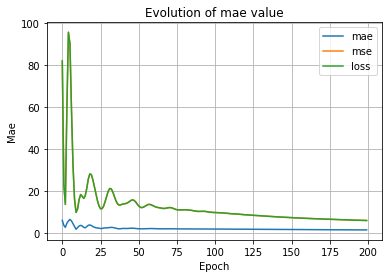

In [333]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

plt.plot(np.arange(len(history.history["val_mae"])),history.history["val_mae"],label="mae")
plt.plot(np.arange(len(history.history["val_mae"])),history.history["val_mse"],label="mse")
plt.plot(np.arange(len(history.history["val_mae"])),history.history["val_loss"],label="loss")
plt.title("Evolution of mae value")
plt.xlabel("Epoch")
plt.ylabel("Mae")
plt.grid()
plt.legend()
plt.show()

In [334]:
# pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
#                                 'MAE' :['mae', 'val_mae'],
#                                 'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Make a prediction
The data must be normalized with the parameters (mean, std) previously used.

In [335]:
new_data = Block.all["2015BD"].to_ai_ready()[:-4]

new_data = (new_data - mean) / std

new_data=np.array(new_data).reshape(1,len(new_data))

1/1 [==============================] - 0s 52ms/step
[[ 1.0255556  27.553131    1.2921231  -0.73210394]]


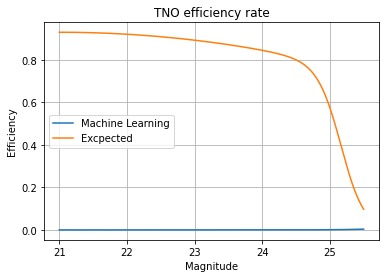

In [336]:

predictions = model.predict( new_data )
print(predictions)

def ft(m,a,b,c,d):
    return a/4 * (1-np.tanh((m-b)/c)) * (1-np.tanh((m-b)/d))

def fs(m,a,b,c,d):
    return (a-b*(m-21)**2) / (1+np.exp((m-c)/d))

m = np.linspace(21,25.5,1000)
plt.plot(m,ft(m,*predictions[0]), label="Machine Learning")
plt.plot(m,fs(m,0.930487275,9.34686325E-03,25.1766472,0.171281680), label="Excpected")
plt.grid()
plt.legend()
plt.title("TNO efficiency rate")
plt.xlabel("Magnitude")
plt.ylabel("Efficiency")
plt.show()